# Hydrogen gas molecule dissociation


**Reference solution**

In [5]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from basistool import compute_integrals
from tqdm import tqdm

In [6]:
# Integrals
margin = 2.0
dists = np.geomspace(0.7, 8.0, 40)
datas = []
for dist in tqdm(dists):
    zgrid = np.arange(-dist / 2 - margin, dist / 2 + margin, 0.02)
    points = np.zeros((len(zgrid), 3))
    points[:, 2] = zgrid
    data = compute_integrals(
        ["H", "H"], [[0.0, 0.0, -dist / 2], [0.0, 0.0, dist / 2]], "aug-cc-pvdz.gbs", points
    )
    datas.append(data)

100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


In the following cell, all lines that end with a `# RHF` comment contain RHF-specific code.

In [7]:
def solve_rhf():
    for dist, data in zip(tqdm(dists), datas, strict=False):
        # Get a few operators.
        coreham = data["kei"] + data["nai"]
        eri = data["eri"]
        olp = data["oi"]
        data["hcore"] = coreham
        
        # The initial guess.
        eigvals, eigvecs = sp.linalg.eigh(coreham, olp)
        dm = np.dot(eigvecs[:, :1], eigvecs[:, :1].T)  # RHF

        # The scf cycle (See 02_helium.ipynb for details.)
        for _scf_counter in range(500):
            hartree = np.einsum("kmln,nm->kl", eri, dm)
            exchange = np.einsum("kmnl,nm->kl", eri, dm)
            fock = coreham + 2 * hartree - exchange  # Specific for RHF

            errors_rh = np.dot(fock, eigvecs) - np.einsum("ij,jk,k->ik", olp, eigvecs, eigvals)
            error_rh = np.linalg.norm(errors_rh)  # Frobenius norm
            if error_rh < 1e-7:
                break

            eigvals, eigvecs = sp.linalg.eigh(fock, olp)
            dm = np.dot(eigvecs[:, :1], eigvecs[:, :1].T)
        else:
            raise RuntimeError("SCF convergence failed")

        # Compute the _electronic_ energy.
        ham = coreham + hartree - 0.5 * exchange  #  RHF
        electronic_energy = 2 * np.einsum("ij,ji", ham, dm)  # RHF

        # Compute the occupied orbital on the grid.
        psi0 = np.dot(eigvecs[:, 0], data["bfs"])  # RHF

        # Store results back into the data dictionary.
        # (Mind the two electrons.)
        data["eigvals_rhf"] = eigvals
        data['eigvecs_rhf'] = eigvecs
        data["energy_rhf"] = electronic_energy + 1 / dist
        data["density_rhf"] = 2 * psi0**2  # RHF


solve_rhf()

100%|██████████| 40/40 [00:00<00:00, 484.31it/s]


In the following cell, all lines that end with a `# UHF` comment contain UHF-specific code.

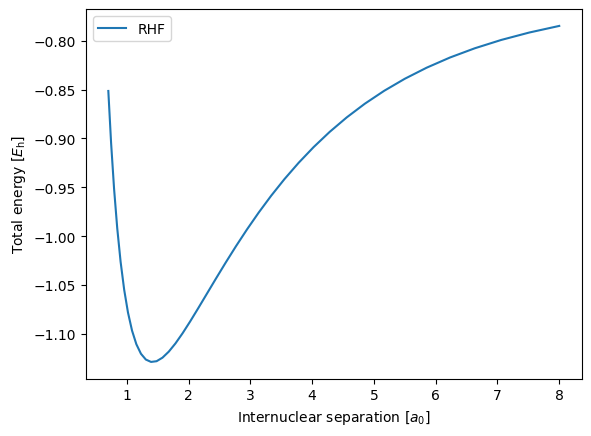

In [8]:
def plot_energy():
    plt.close("dissoc")
    _fig, ax = plt.subplots(num="dissoc")
    ax.plot(dists, [data["energy_rhf"] for data in datas], label="RHF")
    ax.set_xlabel(r"Internuclear separation [$a_0$]")
    ax.set_ylabel(r"Total energy [$E_\mathrm{h}$]")
    ax.legend()


plot_energy()

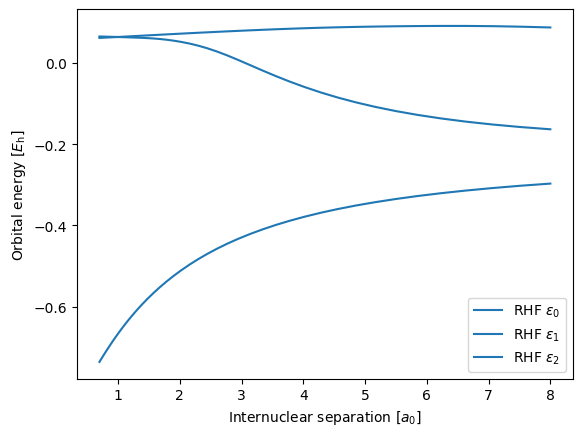

In [9]:
def plot_eigvals():
    plt.close("eigvals")
    _fig, ax = plt.subplots(num="eigvals")
    for ieval in range(3):
        ax.plot(
            dists,
            [data["eigvals_rhf"][ieval] for data in datas],
            label=rf"RHF $\epsilon_{ieval}$",
            color="C0",
        )
    
    ax.set_xlabel(r"Internuclear separation [$a_0$]")
    ax.set_ylabel(r"Orbital energy [$E_\mathrm{h}$]")
    ax.legend()


plot_eigvals()

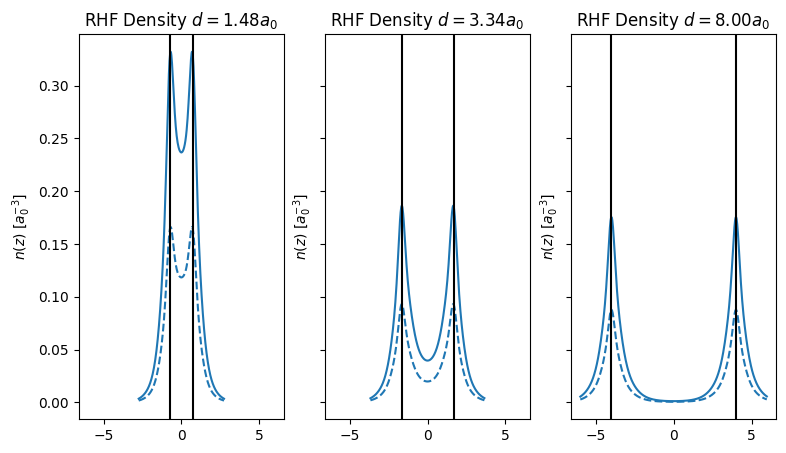

In [10]:
def plot_densities():
    def plot_dens(ax0, i):
        data = datas[i]
        dist = dists[i]

        ax0.set_title(f"RHF Density $d={dist:.2f} a_0$")
        ax0.plot(data["points"][:, 2], data["density_rhf"], "C0-", label="RHF")
        ax0.plot(data["points"][:, 2], data["density_rhf"] / 2, "C0--")
        ax0.axvline(-dist / 2, color="k")
        ax0.axvline(dist / 2, color="k")
        ax0.set_ylabel("$n(z)$ [$a_0^{-3}$]")

    plt.close("densities")
    _fig, axs = plt.subplots(1, 3, num="densities", figsize=(9, 5), sharex=True, sharey=True)
    plot_dens(axs[0], dists.searchsorted(1.4))
    plot_dens(axs[1], dists.searchsorted(3.2))
    plot_dens(axs[2], len(dists) - 1)


plot_densities()

In [11]:
import numpy as np

def solve_ci_singlet_h2(data, dist=None):
    """
    Spin-adapted CI for H2 with 2 electrons (reference + pair doubles).
    Expects in `data`:
      - 'eigvecs_rhf' (or 'eigvecs'/'mo_coeff'): AO->MO coeffs, shape (nao, nmo)
      - 'hcore': AO one-electron integrals (or will use kei+nai if present)
      - 'eri':   AO two-electron integrals (chemist’s notation, same axis order used in SCF)
      - 'energy_rhf': RHF total energy (for reference check)
    Optional: dist (Å) or data["R"] to add nuclear repulsion to the CI total.
    """
    def get_any(d, names):
        for n in names:
            if n in d:
                return d[n]
        raise KeyError(f"Missing required key among {names}")

    C      = get_any(data, ["eigvecs_rhf", "eigvecs", "mo_coeff"])   # (nao, nmo)
    h_ao   = data.get("hcore", data.get("kei", 0) + data.get("nai", 0))
    eri_ao = get_any(data, ["eri"])
    E_rhf  = get_any(data, ["energy_rhf"])

    nmo = C.shape[1]

    # AO -> MO transforms
    h_mo = np.einsum("pi,pq,qj->ij", C, h_ao, C, optimize=True)
    eri_mo = np.einsum("pi,qj,rk,sl,pqrs->ijkl", C, C, C, C, eri_ao, optimize=True)

    # Symmetry sanity
    assert np.allclose(eri_mo, eri_mo.transpose(1,0,3,2))
    assert np.allclose(eri_mo, eri_mo.transpose(2,3,0,1))

    occ = [0]              # one doubly-occupied spatial orbital in H2 minimal RHF
    vir = list(range(1, nmo))

    # CI basis: reference + spin-adapted pair doubles
    basis = [("ref",)]
    for a in vir:
        for b in vir:
            if b < a:
                continue
            basis.append(("dbl", a, b))
    nci = len(basis)
    H = np.zeros((nci, nci))

    def one(i, j): return h_mo[i, j]
    def two(i, j, k, l): return eri_mo[i, j, k, l]

    # Reference diagonal: <Φ0|H|Φ0>
    i = occ[0]
    H[0, 0] = 2*one(i, i) + two(i, i, i, i)

    # Reference–double and double–double blocks
    for I in range(1, nci):
        _, a, b = basis[I]
        if a == b:
            # |aα aβ>
            H[0, I] = 2*two(occ[0], a, occ[0], a)
            H[I, I] = 2*one(a, a) + two(a, a, a, a)
        else:
            # Spin-adapted (|aα bβ> - |aβ bα>)/√2 for S=0
            H[0, I] = np.sqrt(2) * two(occ[0], a, occ[0], b)
            Jab = two(a, a, b, b)
            Kab = two(a, b, b, a)
            H[I, I] = one(a, a) + one(b, b) + Jab - Kab
        H[I, 0] = H[0, I]

    # (For minimal H2 there is only one double; off-diagonal double–double terms are zero.)

    eigvals_ci, eigvecs_ci = np.linalg.eigh(H)
    E_ci_elec = eigvals_ci[0]

    # Add nuclear repulsion if distance is provided
    R = dist if dist is not None else data.get("R", None)
    E_ci_tot = E_ci_elec + (1.0 / R if R is not None else 0.0)

    data["energy_ci_elec"] = E_ci_elec
    data["energy_ci"]      = E_ci_tot
    data["ci_coeffs"]      = eigvecs_ci[:, 0]
    data["ci_basis"]       = basis

    # CI should not be above the reference electronic energy for ground state
    assert E_ci_elec <= H[0,0] + 1e-8, "CI energy higher than reference?"

    return E_ci_tot

In [12]:
for data in datas:
    solve_ci_singlet_h2(data)


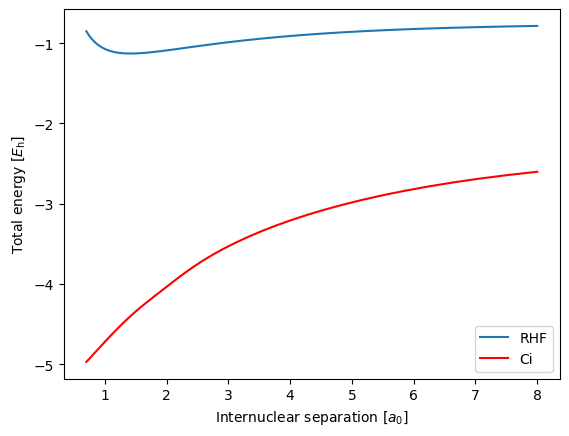

In [13]:
def plot_energy():
    plt.close("dissoc")
    _fig, ax = plt.subplots(num="dissoc")
    ax.plot(dists, [data["energy_rhf"] for data in datas], label="RHF")
    ax.plot(dists, [data["energy_ci"] for data in datas], color = 'red', label="Ci")
    ax.set_xlabel(r"Internuclear separation [$a_0$]")
    ax.set_ylabel(r"Total energy [$E_\mathrm{h}$]")
    ax.legend()


plot_energy()

In [46]:
# choose equilibrium geometry index keq (e.g., the minimum in your scan)
keq = int(np.argmin([d["energy_rhf"] for d in datas]))
data = datas[keq]
C = data["eigvecs_rhf"]      # AO -> MO coefficients (columns = MOs)
bfs = data["bfs"]            # AO basis functions on grid points (from your code)
zgrid = data["density_rhf"]*0 + data["density_rhf"]  # just to get shape if needed

# Build the two lowest spatial MOs on your grid
psi0 = C[:, 0] @ data["bfs"]   # bonding candidate (σg)
psi1 = C[:, 1] @ data["bfs"]   # antibonding candidate (σu)

# Qualitative checks:
# - σg should have no node between nuclei; σu should have one nodal plane at the midpoint.
mid_idx = np.argmin(np.abs(data["points"][:,2]))  # nearest to z=0
print("psi0 midpoint value:", psi0[mid_idx])
print("psi1 midpoint value:", psi1[mid_idx])
# Expect psi0 midpoint large (same sign lobes), psi1 midpoint ~0 with sign change across z=0.

psi0 midpoint value: 0.36181446857056276
psi1 midpoint value: 0.0002566084641474197


In [47]:
import numpy as np

def ao_to_mo_2orb(data):
    C = data["eigvecs_rhf"][:, :2]   # keep 2 lowest MOs
    h_ao = data["hcore"]
    eri_ao = data["eri"]             # chemists' notation (μν|λσ)
    h = C.T @ h_ao @ C
    g = np.einsum("pqrs,pi,qj,rk,sl->ijkl", eri_ao, C, C, C, C, optimize=True)
    return h, g

h, g = ao_to_mo_2orb(data)

In [ ]:
def ci_block_singlet_2orb(h, g):
    h00, h11 = h[0,0], h[1,1]
    h01 = h[0,1]
    g0000 = g[0,0,0,0]
    g1111 = g[1,1,1,1]
    g0011 = g[0,0,1,1]
    g0110 = g[0,1,1,0]
    g0101 = g[0,1,0,1]
    g0001 = g[0,0,0,1]
    g0111 = g[0,1,1,1]

    H = np.zeros((3,3))
    # Diagonal elements (Coulomb + exchange + one-electron):

    H[0,0] = 2*h00 + g0000
    H[1,1] =0 # h00 + h11 + g0101 - g0110 #Coulomb minus exchange
    H[2,2] = 2*h11 + g1111
    # Off-diagonals (couplings by one- and two-electron terms):
    H[0,1] = H[1,0] = 0
    H[1,2] =0 # H[2,1] = np.sqrt(2) * (h01 + g0111)
    H[0,2] = H[2,0] =  g0011 #- g0110 #no exchange subtraction for opposite spins otherwise no singlet
    #
    return H

H = ci_block_singlet_2orb(h, g)
print("CI Hamiltonian matrix (Ha):\n", H)
eigvals, eigvecs = np.linalg.eigh(H)
E_elec = eigvals[0]               # lowest singlet CI electronic energy
E_tot = E_elec + 1.0 / dists[keq] # add nuclear repulsion
print("Singlet CI eigenvalues (Ha):", eigvals)
print("CI ground-state total energy (Ha):", E_tot)
print("RHF total energy at this R (Ha):", data["energy_rhf"])

CI Hamiltonian matrix (Ha):
 [[-0.90986461  0.          0.1933399 ]
 [ 0.          0.          0.        ]
 [ 0.1933399   0.         -0.89186784]]
Singlet CI eigenvalues (Ha): [-1.09441542e+00 -7.07317038e-01  6.00254047e-18]
CI ground-state total energy (Ha): -0.3758042280782864
RHF total energy at this R (Ha): -0.7848646108994394


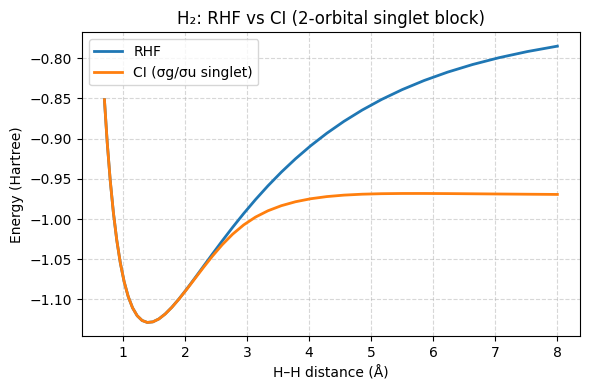

In [51]:
E_rhf = []
E_ci  = []

for R, data in zip(dists, datas, strict=False):
    # RHF total energy was stored as energy_rhf (already includes nuclear repulsion)
    E_rhf.append(data["energy_rhf"])

    # CI (3×3 singlet block)
    h, g = ao_to_mo_2orb(data)
    H = ci_block_singlet_2orb(h, g)
    eigvals, _ = np.linalg.eigh(H)
    E_ci.append(eigvals[0] + 1.0 / R)  # add nuclear repulsion

E_rhf = np.array(E_rhf)
E_ci  = np.array(E_ci)

# --- Plot ---

plt.figure(figsize=(6,4))
plt.plot(dists, E_rhf, label="RHF", lw=2)
plt.plot(dists, E_ci,  label="CI (σg/σu singlet)", lw=2)
plt.xlabel("H–H distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H₂: RHF vs CI (2-orbital singlet block)")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("rhf_vs_ci.png", dpi=200)
plt.show()